# 写在前面

上周没安排好时间，最后上交的作业是网上找的+改了部分参数（还改得很劣质）。态度不端正耽误您时间，我非常抱歉。

这周在上周的基础上，留用了Alpha7因子，根据上周观察到的现象重新做了进出场信号假设并实现。除了做多方面的盈亏比在0.9左右，其他数据均满足最低要求。
弃用了MACD（做出来效果很不好），改观察蜡烛图。参考课件CandleResearch上网站http://www.stockstowatch.com/candle-indicator/ 的测试绩效，选定了HOMINGPIGEON信号搭配INVERTEDHAMMER形态（比较了DRAGONFLYDOJI、UNIQUE3RIVER、TAKURI、INVERTEDHAMMER、GRAVESTONEDOJI、MATCHINGLOW在比特币市场的适用性，加入测试心理考量，发现INVERTEDHAMMER效果最好），结果：在'BTCUSDT:binance'和"EOSUSDT:binance"下能实现较高胜率与盈亏比。

最后，感谢助教与老师们这段时间来对我的指导，感谢GSICE校园直通车给我这次线上学习提升自己的机会。

# 因子 Alpha7

In [1]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '8H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.9878787994384766


In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()
    
def RankPct(df):
    return df.rank(axis=1, pct=True)

Initialize dataview success.


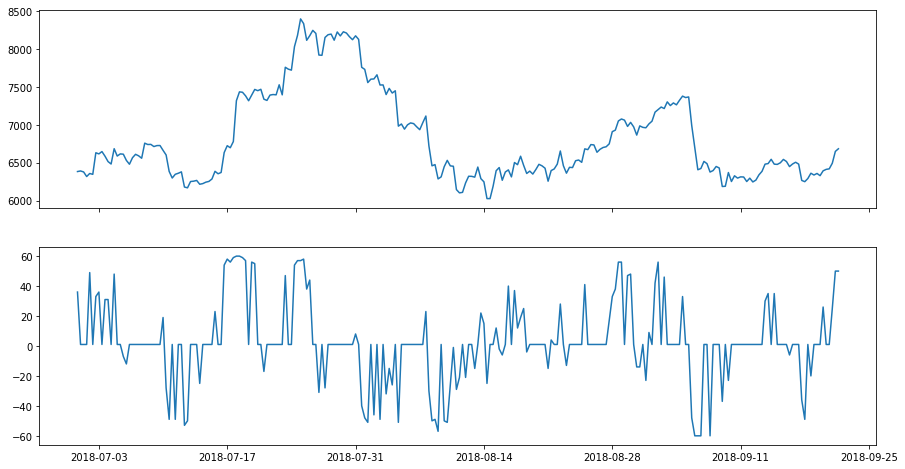

In [3]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha7_plot)

【Alpha7思考】
1. Alpha7因子:-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)  
2. 思考：
为了更直观了解alpha7具体数值变化，输出alpha7数值变化表，并与上两图做对比，可知：
（1）当close下降时，alpha7数值小于0 或 alpha7变化率过小（曲线斜率较低）。
（2）当close变化不大时，alpha7数值基本为0。
（3）当close较快上升时，alpha7变化率激增。
3.总结：
alpha7的数值涨跌与收盘价相似，且会放大收盘价斜率的绝对值激增（即close较快上升/下降）的情况，弱化波动较小的收盘价变化，利于抓取进出场信号。

【信号与进出场条件设置】
long进场：alpha7大于0（基本表示close突然增加）且前一close数值为0。
long出场：short不可进场时
short进场：alpha7小于0（基本表示close突然下降）且前一close数值为0。
short出场：long不可进场时

In [4]:
# 设定进出场条件
long = dv.add_formula('long','If( ((-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1))>0) && Delay(-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1),1)== 0, 2, 0)', add_data=True)
short = dv.add_formula('short','If( ((-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1))<0) && Delay(-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1),1)== 0, -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [5]:
#计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)
tdMaStatistic.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 17%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 66%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.655  -4.462   0.611
p-value              0.000   0.000   0.543
mean                 0.017  -0.020   0.002
std                  0.017   0.021   0.026
info_ratio           0.970  -0.951   0.081
skewness             2.407  -0.997  -0.154
kurtosis             7.023  -0.284   2.162
pct5                 0.002  -0.063  -0.048
pct25                0.005  -0.034  -0.005
pct50                0.012  -0.010   0.003
pct75                0.022  -0.004   0.014
pct95                0.049  -0.000   0.032
occurance           35.000  23.000  58.000
win_ratio              NaN     NaN   0.603
win_mean/loss_mean     NaN     NaN   0.831


In [6]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win    loss      all
t-stat               12.421  -8.129    3.598
p-value               0.000   0.000    0.000
mean                  0.047  -0.038    0.015
std                   0.045   0.043    0.060
info_ratio            1.057  -0.882    0.240
skewness              1.971  -1.797    0.112
kurtosis              4.407   2.739    2.592
pct5                  0.002  -0.162   -0.074
pct25                 0.014  -0.048   -0.013
pct50                 0.039  -0.024    0.011
pct75                 0.060  -0.008    0.048
pct95                 0.155  -0.001    0.091
occurance           139.000  86.000  225.000
win_ratio               NaN     NaN    0.618
win_mean/loss_mean      NaN     NaN    1.236


In [7]:
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               12.735   -8.857    3.633
p-value               0.000    0.000    0.000
mean                  0.041   -0.034    0.012
std                   0.042    0.040    0.055
info_ratio            0.968   -0.852    0.216
skewness              2.155   -1.969    0.217
kurtosis              5.481    3.758    3.392
pct5                  0.002   -0.133   -0.071
pct25                 0.011   -0.046   -0.011
pct50                 0.031   -0.023    0.008
pct75                 0.056   -0.006    0.039
pct95                 0.094   -0.001    0.090
occurance           174.000  109.000  283.000
win_ratio               NaN      NaN    0.615
win_mean/loss_mean      NaN      NaN    1.194


EOS

In [8]:
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '16H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()
    
def RankPct(df):
    return df.rank(axis=1, pct=True)

Initialize dataview success.


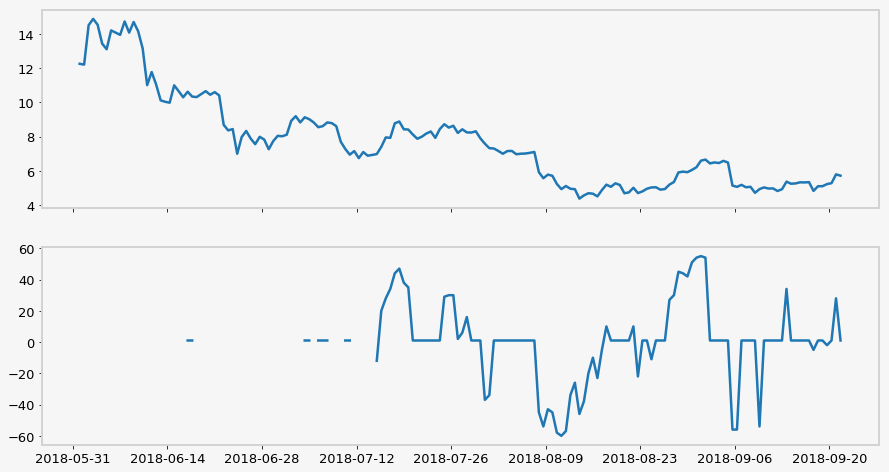

In [9]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha7_plot)

In [10]:
# 设定进出场条件
#long = dv.add_formula('long','If( ((-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1))>0) && Delay(-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1),1)== 0, 2, 0)', add_data=True)

long = dv.add_formula('long','If( ((-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1))>0) && Delay(-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1),1)==0, 2, 0)', add_data=True)
short = dv.add_formula('short','If( ((-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1))<0) && Delay(-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1),1)== 0, -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [11]:
#计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)
tdMaStatistic.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 14%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 48%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.221  -2.909  -0.408
p-value              0.000   0.013   0.687
mean                 0.072  -0.078  -0.009
std                  0.044   0.092   0.105
info_ratio           1.651  -0.840  -0.085
skewness             0.398  -0.906  -0.895
kurtosis            -1.102  -1.032   0.178
pct5                 0.024  -0.237  -0.231
pct25                0.030  -0.164  -0.026
pct50                0.079  -0.025  -0.003
pct75                0.102  -0.013   0.049
pct95                0.139  -0.004   0.121
occurance           11.000  13.000  24.000
win_ratio              NaN     NaN   0.458
win_mean/loss_mean     NaN     NaN   0.930


In [12]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              14.537  -4.158   6.677
p-value              0.000   0.001   0.000
mean                 0.131  -0.072   0.084
std                  0.071   0.074   0.112
info_ratio           1.861  -0.980   0.747
skewness            -0.011  -1.029  -0.681
kurtosis            -1.046  -0.604   0.146
pct5                 0.027  -0.208  -0.161
pct25                0.073  -0.114   0.007
pct50                0.131  -0.035   0.097
pct75                0.202  -0.021   0.169
pct95                0.229  -0.010   0.221
occurance           62.000  19.000  81.000
win_ratio              NaN     NaN   0.765
win_mean/loss_mean     NaN     NaN   1.817


In [13]:
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              14.742  -5.062    5.438
p-value              0.000   0.000    0.000
mean                 0.122  -0.074    0.062
std                  0.070   0.082    0.117
info_ratio           1.737  -0.909    0.533
skewness             0.152  -0.997   -0.610
kurtosis            -1.036  -0.727    0.114
pct5                 0.025  -0.230   -0.190
pct25                0.069  -0.162   -0.013
pct50                0.117  -0.028    0.072
pct75                0.174  -0.020    0.151
pct95                0.224  -0.004    0.221
occurance           73.000  32.000  105.000
win_ratio              NaN     NaN    0.695
win_mean/loss_mean     NaN     NaN    1.645
